# Diffusion Models from Scratch  

This notebook begins with a 'toy' (not exactly) diffusion model to see how the different pieces work, and then examining how they differ from a more complex implementation.

We will look at
- The corruption process (adding noise to data): the noise applied in the first example does not follow the standard formula of diffusion models. It is uniform noise. Then the standard corruption process with gaussian noise is used
- how to implement different U-Nets from scratch, with different blocks of convolutional transformation and different skip connections
- Diffusion model training
- Sampling theory



## Setup and Imports:

In [ ]:
%pip install -q diffusers

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

## The Data

Here we're going to test things with a very small dataset: mnist. If you'd like to give the model a slightly harder challenge without changing anything else, torchvision.datasets.FashionMNIST should work as a drop-in replacement.

In [ ]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

Each image is a greyscale 28px by 28px drawing of a digit, with values ranging from 0 to 1.

## The Corruption Process

We want an easy way to control the amount of corruption. So what if we take in a parameter for the `amount` of noise to add, and then we do:

`noise = torch.rand_like(x)`

`noisy_x =  (1-amount)*x + amount*noise`

If amount = 0, we get back the input without any changes. If amount gets up to 1, we get back noise with no trace of the input x. By mixing the input with noise this way, we keep the output in the same range (0 to 1).



In [ ]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount  # this does not follow the standard formula of diffusion models.

  # Remember that two tensors are broadcastable if (when comparing their dimensions from right to left):
  # - They are equal, or
  # - One of them is 1 (i.e., it can be "stretched" without copying data)
  # In our case x is a batch of images and its shape is (batch_size, channels, height, width)

In [ ]:
# Plotting the input data and showing how corruption process modify the data
fig, axs = plt.subplots(2, 1, figsize=(8, 3))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # torch.linspace(start, end, steps) creates a tensor with
                                          # steps values evenly spaced between start and end (inclusive).
                                          # It creates a list of different "amount", one for each image of the batch
                                          # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');


## The Model

We'd like a model that takes in a 28px noisy images and outputs a prediction of the same shape. A popular choice here is an architecture called a UNet. [Originally invented for segmentation tasks in medical imagery](https://arxiv.org/abs/1505.04597), a UNet consists of a 'constricting path' through which data is compressed down and an 'expanding path' through which it expands back up to the original dimension (similar to an autoencoder) but also features skip connections that allow for information and gradients to flow across at different levels.

Some UNets feature complex blocks at each stage, but for this toy demo we'll build a minimal example that takes in a one-channel image and passes it through three convolutional layers on the down path (the down_layers in the diagram and code) and three on the up path, with skip connections between the down and up layers. We'll use max pooling for downsampling and `nn.Upsample` for upsampling rather than relying on learnable layers like more complex UNets. Here is the rough architecture showing the number of channels in the output of each layer:

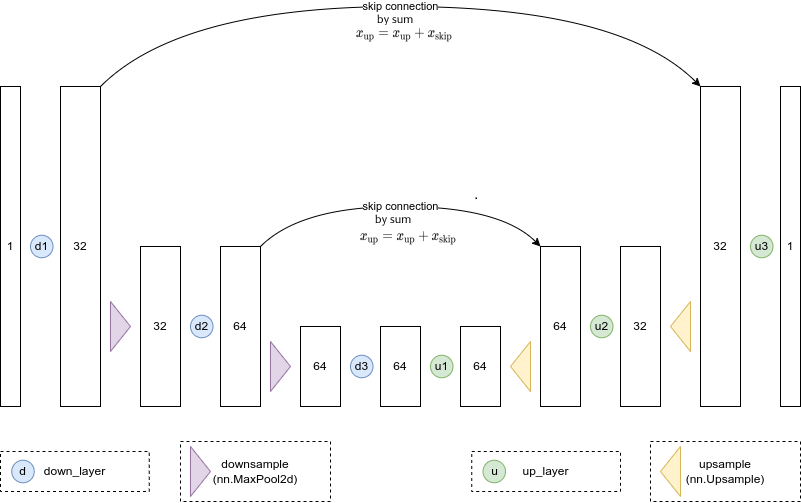


This is what that looks like in code:

In [ ]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([

                   #...

        ])
        self.up_layers = torch.nn.ModuleList([

                   #...

        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):

        #  TO DO

        return x

# SiLU(𝑥) = 𝑥 ⋅ σ(𝑥)  
For large positive 𝑥 , it behaves like 𝑥;

For large negative 𝑥 , it goes smoothly to 0 (but not abruptly like ReLU)

It's smooth and differentiable everywhere, unlike ReLU which has a hard zero for 𝑥<0

Compared to ReLU:

It avoids dead neurons since it's never exactly 0 unless
𝑥=0

It tends to perform better in some deep architectures due to its smoothness

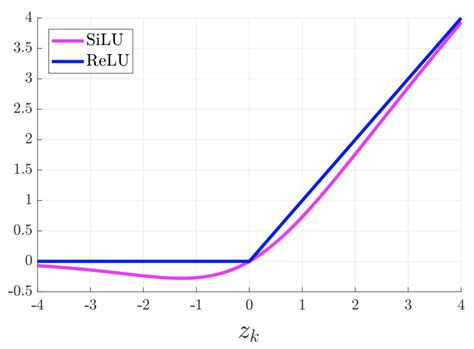

## The Model with skip connection by concatenation

When skip connections are implemented via concatenation along the channel dimension (as in the original U-Net), the resulting tensor has an increased number of channels.

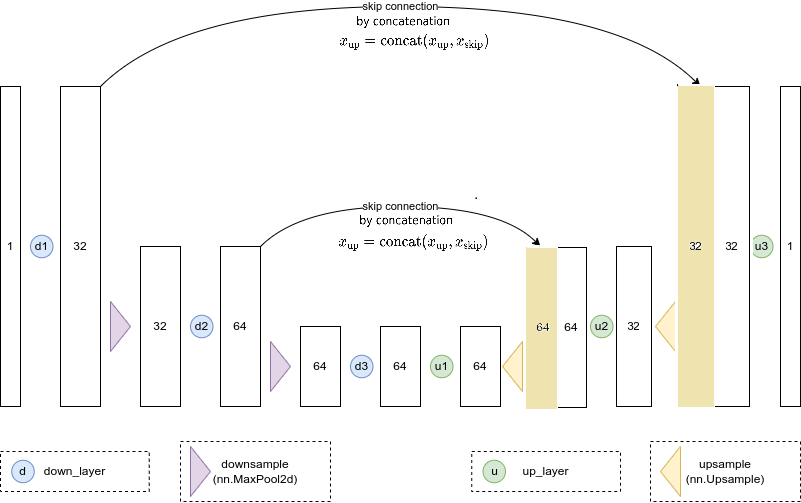

In [ ]:

class UNetWithConcatSkip(nn.Module):
    """UNet with skip connection by concatenation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        # Encoder (downsampling)
        self.down_layers = nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding="same"),
            nn.Conv2d(32, 64, kernel_size=5, padding="same"),
            nn.Conv2d(64, 64, kernel_size=5, padding="same"),
        ])

        # Decoder (upsampling)
        self.up_layers = nn.ModuleList([

                   # ...

        ])

        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []

        # Downsampling
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:
                h.append(x)       # Save for skip connection
                x = self.downscale(x)

        # Upsampling

       # TO DO

        return x


## Training process

## Training the network

We can implement different training methods (remember the three different options described in the slides). At first we implement the option B: given a corrupted input noisy_x the model should output its best guess for what the original x looks like. We will compare this to the actual value via the mean squared error.

- Get a batch of data
- Corrupt it by random amounts
- Feed it through the model
- Compare the model predictions with the clean images to calculate our loss
- Update the model's parameters accordingly.


In [ ]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
n_epochs = 5

# Create the network and print num params


# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version

        #....

        # Get the model prediction

        # ...

        # Calculate the loss

        # ...

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

In [ ]:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(8, 4))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

plt.tight_layout()
plt.show()

## Sampling after training
In each iteration:

It passes the current image x through a trained model (net) to get pred.

Then, it linearly interpolates between the current x and pred using a time-dependent mix factor.

This is a naive denoising loop, progressively moving from noise to a more “image-like” output using the network. It does not represent the sampling process in a diffusion model but it is coherent with the corruption process proposed in this example

In [ ]:
n_steps = 100
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  t = torch.full((batch_size,), i / n_steps, device=device)  # normalize t in [0,1]

  with torch.no_grad():
    pred_noise = net(x,t)
  alpha = 1 - (i / n_steps)
  beta = 1 - alpha

    # Denoise step (simple blending, you can design better schedules)
  x = x * alpha + pred_noise * beta

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

You can see that for the lower amounts the predictions are pretty good! But as the level gets very high there is less for the model to work with, and by the time we get to amount=1 it outputs a blurry mess close to the mean of the dataset to try and hedge its bets on what the output might look like...

## Sampling from different noised input

If our predictions at high noise levels aren't very good, how do we generate images?

Well, what if we start from random noise, look at the model predictions but then only move a small amount towards that prediction - say, 20% of the way there. Now we have a very noisy image in which there is perhaps a hint of structure, which we can feed into the model to get a new prediction. The hope is that this new prediction is slightly better than the first one (since our starting point is slightly less noisy) and so we can take another small step with this new, better prediction.

Repeat a few times and (if all goes well) we get an image out! We visualize the model input (left) and the predicted denoised images (right) at each stage. Note that even though the model predicts the denoised image even at step 1, we only move x part of the way there. Over a few steps the structures appear and are refined, until we get our final outputs.

In [ ]:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]   # Creates a copy of x without gradients (to avoid tracking operations),
                                    # Moves that copy from the GPU to the CPU
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

Not great, but there are some recognizable digits there! You can experiment with training for longer (say, 10 or 20 epochs) and tweaking model config, learning rate, optimizer and so on. Also, don't forget that fashionMNIST is a one-line replacement if you want a slightly harder dataset to try.

## Original Diffusion Model and U-Net
Now we can move formward the original diffusion model.
We need to change:
- noise adding phase
- U-Net model
- sampling process



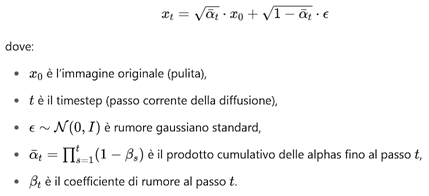

In [ ]:
def q_sample(x_start, t, betas):
    """
    Diffusion noising step for MNIST images.

    Args:
        x_start: clean MNIST images, shape (batch_size, 1, 28, 28)
        t: tensor of timesteps, shape (batch_size,)
        betas: noise schedule tensor, shape (T,)

    Returns:
        x_t: noisy images at step t, same shape as x_start
    """
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)  # cumulative product of alphas

    alpha_bar_t = alphas_cumprod[t].view(-1, 1, 1, 1)  # reshape for broadcasting

    noise = torch.randn_like(x_start)  # noise same shape as input

    x_t = torch.sqrt(alpha_bar_t) * x_start + torch.sqrt(1 - alpha_bar_t) * noise
    return x_t, noise


# Example usage with MNIST-like data:

T = 1000
betas = torch.linspace(1e-4, 0.02, T)

batch_size = 8
channels = 1  # grayscale
height = 28
width = 28

# Dummy MNIST images (normally you'd load real MNIST)
x_start = torch.randn(batch_size, channels, height, width)

t = torch.randint(0, T, (batch_size,))

x_noisy, noise = q_sample(x_start, t, betas)
print(x_noisy.shape)  # (8, 1, 28, 28)


A more standard U-Net able to use time t (without any emebedding) and to predict the noise instead of the original image

In [ ]:
class DoubleConv(nn.Module):
    """(Conv => BatchNorm => SiLU) * 2 with time concatenation"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels + 1, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True),
        )

    def forward(self, x, t):
        # x: (B, C, H, W), t: (B,)
        B, _, H, W = x.shape
        t_feat = t.view(B, 1, 1, 1).expand(-1, 1, H, W)  # (B, 1, H, W)
        x = torch.cat([x, t_feat], dim=1)
        return self.block(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x, t):
        x = self.pool(x)
        return self.conv(x, t)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2, t):
        x1 = self.up(x1)
        if x1.shape[2:] != x2.shape[2:]:
            x1 = F.interpolate(x1, size=x2.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x, t)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.inc = DoubleConv(in_channels, features[0])
        self.down1 = Down(features[0], features[1])
        self.down2 = Down(features[1], features[2])
        self.down3 = Down(features[2], features[3])
        self.bottom = DoubleConv(features[3], features[3]*2)
        self.up3 = Up(features[3]*2, features[3])
        self.up2 = Up(features[3], features[2])
        self.up1 = Up(features[2], features[1])
        self.up0 = Up(features[1], features[0])
        self.outc = nn.Conv2d(features[0], out_channels, kernel_size=1)


    def forward(self, x, t):
        x1 = self.inc(x, t)
        x2 = self.down1(x1, t)
        x3 = self.down2(x2, t)
        x4 = self.down3(x3, t)
        x5 = self.bottom(x4, t)
        x = self.up3(x5, x4, t)
        x = self.up2(x, x3, t)
        x = self.up1(x, x2, t)
        x = self.up0(x, x1, t)
        return self.outc(x)

In [ ]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
n_epochs = 25

# Create the network
net = UNet()  # training takes 1,3 mins for epoch

net.to(device)
print("Number of parameters: ",sum([p.numel() for p in net.parameters()]))

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        #noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        t = torch.randint(0, T, (x.shape[0],)).to(device)
        noisy_x, noise = q_sample(x, t, betas.to(device)) # Create our noisy x

        # Get the model prediction
        pred_noise = net(noisy_x,t)

        # Calculate the loss
        loss = loss_fn(pred_noise, noise) # In this case we are training by minimizing the error on the reconstructed noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

#Sampling
How to create new data

In [ ]:
import torch

@torch.no_grad()
def p_sample_loop(betas, shape, device):
    T = len(betas)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    x_t = torch.randn(shape).to(device)  # Start from Gaussian noise

    for t in reversed(range(T)):
        t_tensor = torch.full((shape[0],), t, dtype=torch.long, device=device)

        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alphas_cumprod[t]

        # Predict the noise with the model
        pred_noise = net(x_t, t_tensor)

        # Compute mean of the reverse process
        coef1 = 1 / torch.sqrt(alpha_t)
        coef2 = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
        mean = coef1 * (x_t - coef2 * pred_noise)

        if t > 0:
            noise = torch.randn_like(x_t)
            sigma_t = torch.sqrt(beta_t)
            x_t = mean + sigma_t * noise
        else:
            x_t = mean  # Last step, no noise

    return x_t  # Final denoised sample (hopefully close to data)


# Assume: model is trained UNet, betas is torch.linspace(1e-4, 0.02, T), T = 1000
betas = torch.linspace(1e-4, 0.02, 1000).to(device)

sampled_imgs = p_sample_loop(
    betas=betas,
    shape=(16, 1, 28, 28),  # batch of 16 MNIST-like images
    device=device
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(torchvision.utils.make_grid(sampled_imgs.detach().cpu(), nrow=4)[0].clip(0, 1), cmap='Greys')

## Comparison To DDPM

In this section we'll take a look at how our toy implementation differs from the approach used in the other notebook ([Introduction to Diffusers](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb)), which is based on the DDPM paper.

We'll see that


*   The diffusers `UNet2DModel` is a bit more advanced than our BasicUNet
*   The corruption process in handled differently
*   The training objective is different, involving predicting the noise rather than the denoised image
*   The model is conditioned on the amount of noise present via timestep conditioning, where t is passed as an additional argument to the forward method.
*   There are a number of different sampling strategies available, which should work better than our simplistic version above.

There have been a number of improvements suggested since the DDPM paper came out, but this example is hopefully instructive as to the different available design decisions. Once you've read through this, you may enjoy diving into the paper ['Elucidating the Design Space of Diffusion-Based Generative Models'](https://arxiv.org/abs/2206.00364) which explores all of these components in some detail and makes new recommendations for how to get the best performance.

If all of this is too technical or intimidating, don't worry! Feel free to skip the rest of this notebook or save it for a rainy day.




### The UNet

The diffusers UNet2DModel model has a number of improvements over our basic UNet above:

*   GroupNorm applies group normalization to the inputs of each block
*   Dropout layers for smoother training
*   Multiple resnet layers per block (if layers_per_block isn't set to 1)
*   Attention (usually used only at lower resolution blocks)
*   Conditioning on the timestep.
*   Downsampling and upsampling blocks with learnable parameters

Let's create and inspect a UNet2DModel:



In [ ]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
print(model)

As you can see, a little more going on! It also has significantly more parameters than our BasicUNet:

In [ ]:
sum([p.numel() for p in model.parameters()]) # 1.7M vs the ~309k parameters of the BasicUNet

We can replicate the training shown above using this model in place of our original one. We need to pass both x and timestep to the model (here I always pass t=0 to show that it works without this timestep conditioning and to keep the sampling code easy, but you can also try feeding in `(amount*1000)` to get a timestep equivalent from the corruption amount). Lines changed are shown with `#<<<` if you want to inspect the code.

In [ ]:

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 30  #time for training: 1,7 mins for each epoch

# Create the network
bigger_net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
bigger_net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(bigger_net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = bigger_net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(
            bigger_net.state_dict(),
            f"model_epoch_{epoch+1}.pt"
        )
        print(f"Saved model at epoch {epoch+1}")

# Plot losses
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(losses)
ax.set_ylim(0, 0.1)
ax.set_title('Loss over time')




In [ ]:

# Paths to your saved model weights
model_paths = ["model_epoch_10.pt", "model_epoch_20.pt"]

# Create figure
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Loop over both models
for model_index, model_path in enumerate(model_paths):
    # Load model weights
    bigger_net.load_state_dict(torch.load(model_path))
    #bigger_net.eval()  # Set to evaluation mode
    print(f'm_ind={model_index}; m_path={model_path}')
    # Reset input noise
    x = torch.rand(64, 1, 28, 28).to(device)

    # Run denoising process
    n_steps = 300
    for i in range(n_steps):
        noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps))  # Noise schedule

        with torch.no_grad():
            pred = bigger_net(x, 0).sample  # Assume model returns a .sample property

        mix_factor = 1 / (n_steps - i)
        x = x * (1 - mix_factor) + pred * mix_factor

        if i % 100 == 99:
            p = i // 100
            ax[model_index][p].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
            ax[model_index][p].set_title(f'Model {"10 epochs" if model_index == 0 else "20 epochs"} after {i} steps')

plt.tight_layout()
plt.show()


In [ ]:
# Samples
n_steps = 300
x = torch.rand(64, 1, 28, 28).to(device)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = bigger_net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
  if i % 100 == 99:
    p=i//100
    ax[p].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
    ax[p].set_title(f'Generated Samples after {i} steps')



This looks quite a bit better than our first set of results! You can explore tweaking the unet configuration or training for longer to get even better performance.

### The Corruption Process

The DDPM paper describes a corruption process that adds a small amount of noise for every 'timestep'. Given $x_{t-1}$ for some timestep, we can get the next (slightly more noisy) version $x_t$ with:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


That is, we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\beta_t$. This $\beta$ is defined for every t according to some schedule, and determines how much noise is added per timestep. Now, we don't necessarily want to do this operation 500 times to get $x_{500}$ so we have another formula to get $x_t$ for any t given $x_0$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, \sqrt{(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>

The maths notation always looks scary! Luckily the scheduler handles all that for us (uncomment the next cell to check out the code). We can plot $\sqrt{\bar{\alpha}_t}$ (labelled as `sqrt_alpha_prod`) and $\sqrt{(1 - \bar{\alpha}_t)}$ (labelled as `sqrt_one_minus_alpha_prod`) to view how the input (x) and the noise are scaled and mixed across different timesteps:


In [ ]:
#??noise_scheduler.add_noise

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Initially, the noisy x is mostly x (sqrt_alpha_prod ~= 1) but over time the contribution of x drops and the noise component increases. Unlike our linear mix of x and noise according to `amount`, this one gets noisy relatively quickly. We can visualize this on some data:

In [ ]:
#@markdown visualize the DDPM noising process for different timesteps:

# Noise a batch of images to view the effect
fig, axs = plt.subplots(3, 1, figsize=(8, 5))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1. # Map to (-1, 1)
print('X shape', xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('Noisy X');

Another dynamic at play: the DDPM version adds noise drawn from a Gaussian distribution (mean 0, s.d. 1 from torch.randn) rather than the uniform noise between 0 and 1 (from torch.rand) we used in our original `corrupt` function. In general, it makes sense to normalize the training data as well. In the other notebook, you'll see `Normalize(0.5, 0.5)` in the list of transforms, which maps the image data form (0, 1) to (-1, 1) and is 'good enough' for our purposes. We didn't do that for this notebook, but the visualization cell above adds it in for more accurate scaling and visualization.

### Training Objective

In our toy example, we had the model try to predict the denoised image. In DDPM and many other diffusion model implementations, the model predicts the noise used in the corruption process (before scaling, so unit variance noise). In code, it looks something like:

```python
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
model_prediction = model(noisy_x, timesteps).sample
loss = mse_loss(model_prediction, noise) # noise as the target
```

You may think that predicting the noise (from which we can derive what the denoised image looks like) is equivalent to just predicting the denoised image directly. So why favour one over the other - is it just for mathematical convenience?

It turns out there's another subtlety here. We compute the loss across different (randomly chosen) timesteps during training. These different objectives will lead to different 'implicit weighting' of these losses, where predicting the noise puts more weight on lower noise levels. You can pick more complex objectives to change this 'implicit loss weighting'. Or perhaps you choose a noise schedule that will result in more examples at a higher noise level. Perhaps you have the model predict a 'velocity' v which we define as being a combination of both the image and the noise dependent on the noise level (see 'PROGRESSIVE DISTILLATION FOR FAST SAMPLING OF DIFFUSION MODELS'). Perhaps you have the model predict the noise but then scale the loss by some factor dependent on the amount of noise based on a bit of theory (see 'Perception Prioritized Training of Diffusion Models') or based on experiments trying to see what noise levels are most informative to the model (see 'Elucidating the Design Space of Diffusion-Based Generative Models'). TL;DR: choosing the objective has an effect on model performance, and research in ongoing into what the 'best' option is.

At the moment, predicting the noise (epsilon or eps you'll see in some places) is the favoured approach but over time we will likely see other objectives supported in the library and used in different situations.



### Timestep Conditioning

The UNet2DModel takes in both x and timestep. The latter is turned into an embedding and fed into the model in a number of places.

The theory behind this is that by giving the model information about what the noise level is, it can better perform its task. While it is possible to train a model without this timestep conditioning, it does seem to help performance in some cases and most implementations include it, at least in the current literature.

### Sampling

Given a model that estimates the noise present in a noisy input (or predicts the denoised version), how do we produce new images?

We could feed in pure noise, and hope that the model predicts a good image as the denoised version in one step. However, as we saw in the experiments above, this doesn't usually work well. So, instead, we take a number of smaller steps based on the model prediction, iteratively removing a little bit of the noise at a time.

Exactly how we take these steps depends on the sampling method used. We won't go into the theory too deeply, but some key design questions are:
- How large of a step should you take? In other words, what 'noise schedule' should you follow?
- Do you use only the model's current prediction to inform the update step (like DDPM, DDIM and many others)? Do you evaluate the model several times to estimate higher-order gradients for a larger, more accurate step (higher-order methods and some discrete ODE solvers)? Or do you keep a history of past predictions to try and better inform the current update step (linear multi-step and ancestral samplers)?
- Do you add in additional noise (sometimes called churn) to add more stochasticity (randomness) to the sampling process, or do you keep it completely deterministic? Many samplers control this with a parameter (such as 'eta' for DDIM samplers) so that the user can choose.

Research on sampling methods for diffusion models is rapidly evolving, and more and more methods for finding good solutions in fewer steps are being proposed. The brave and curious might find it interesting to browse through the code of the different implementations available in the diffusers library [here](https://github.com/huggingface/diffusers/tree/main/src/diffusers/schedulers) or check out the [docs](https://huggingface.co/docs/diffusers/api/schedulers/overview) which often link to the relevant papers.

## Conclusions

Hopefully this has been a helpful way to look at diffusion models from a slightly different angle.

This notebook was written for this Hugging Face course by Jonathan Whitaker, and overlaps with a [version included in his own course](https://johnowhitaker.github.io/tglcourse/dm1.html), 'The Generative Landscape'. Check that out if you'd like to see this basic example extended with noise and class conditioning. Questions or bugs can be communicated through GitHub issues or via Discord. You are also welcome to reach out via Twitter [@johnowhitaker](https://twitter.com/johnowhitaker).